### Baseball Hall of Fame Player Classification using K-Nearest Neighbours
A machine learning project implementing binary classification on 500 hits dataset using K-Nearest Neighbours model.

### Project Documentation

#### Overview
This project demonstrates the complete machine learning workflow for binary classification:

- Exploratory Data Analysis (EDA) of baseball career statistics
- Feature scaling comparison and selection
- K-Nearest Neighbors model implementation with hyperparameter tuning
- Performance analysis using confusion matrix and classification metrics

#### Results
- Model: K-Nearest Neighbors (k=11)
- Accuracy: 88% on test set (93 samples)
- Precision: 90% for Hall of Fame predictions
- Class distribution: 65 non-HOF, 28 HOF players in test set

#### Key Findings
- RobustScaler outperformed StandardScaler due to outliers in baseball statistics (e.g., exceptional HR or SB records)
- Optimal k=20 was determined through 5-fold cross-validation, balancing bias-variance tradeoff
- Career statistics alone can predict HOF induction with high accuracy, suggesting objective performance metrics strongly influence voting decisions, model shows conservative prediction behavior:

    1. HOF Precision: 90% (very accurate when predicting HOF)
    2.  HOF Recall: 68% (misses some HOF players)
    3.  Non-HOF Recall: 97% (excellent at identifying non-HOF players) 



### Importing the required modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### Importing and understanding the dataset

In [2]:
df = pd.read_csv("500hits.csv", encoding='latin-1')

In [3]:
df.head()

,PLAYER,YRS,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,BA,HOF
0,Ty Cobb,24,3035,11434,2246,4189,724,295,117,726,1249,357,892,178,0.366,1
1,Stan Musial,22,3026,10972,1949,3630,725,177,475,1951,1599,696,78,31,0.331,1
2,Tris Speaker,22,2789,10195,1882,3514,792,222,117,724,1381,220,432,129,0.345,1
3,Derek Jeter,20,2747,11195,1923,3465,544,66,260,1311,1082,1840,358,97,0.310,1
4,Honus Wagner,21,2792,10430,1736,3430,640,252,101,0,963,327,722,15,0.329,1


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.head()

,player,yrs,g,ab,r,h,2b,3b,hr,rbi,bb,so,sb,cs,ba,hof
0,Ty Cobb,24,3035,11434,2246,4189,724,295,117,726,1249,357,892,178,0.366,1
1,Stan Musial,22,3026,10972,1949,3630,725,177,475,1951,1599,696,78,31,0.331,1
2,Tris Speaker,22,2789,10195,1882,3514,792,222,117,724,1381,220,432,129,0.345,1
3,Derek Jeter,20,2747,11195,1923,3465,544,66,260,1311,1082,1840,358,97,0.310,1
4,Honus Wagner,21,2792,10430,1736,3430,640,252,101,0,963,327,722,15,0.329,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   player  465 non-null    object 
 1   yrs     465 non-null    int64  
 2   g       465 non-null    int64  
 3   ab      465 non-null    int64  
 4   r       465 non-null    int64  
 5   h       465 non-null    int64  
 6   2b      465 non-null    int64  
 7   3b      465 non-null    int64  
 8   hr      465 non-null    int64  
 9   rbi     465 non-null    int64  
 10  bb      465 non-null    int64  
 11  so      465 non-null    int64  
 12  sb      465 non-null    int64  
 13  cs      465 non-null    int64  
 14  ba      465 non-null    float64
 15  hof     465 non-null    int64  
dtypes: float64(1), int64(14), object(1)
memory usage: 58.3+ KB


In [7]:
df.duplicated().sum()

np.int64(0)

#### cleaning the outcome variable

In [8]:
df['hof'].value_counts()

hof
0    313
1    151
2      1
Name: count, dtype: int64

In [9]:
df[df['hof'] == 2]

,player,yrs,g,ab,r,h,2b,3b,hr,rbi,bb,so,sb,cs,ba,hof
160,Tim Raines Sr.,23,2502,8872,1571,2605,430,113,170,980,1330,966,808,146,0.294,2


In [10]:
df = df.drop(160)

In [11]:
df['hof'].value_counts()

hof
0    313
1    151
Name: count, dtype: int64

In [12]:
df.head()

,player,yrs,g,ab,r,h,2b,3b,hr,rbi,bb,so,sb,cs,ba,hof
0,Ty Cobb,24,3035,11434,2246,4189,724,295,117,726,1249,357,892,178,0.366,1
1,Stan Musial,22,3026,10972,1949,3630,725,177,475,1951,1599,696,78,31,0.331,1
2,Tris Speaker,22,2789,10195,1882,3514,792,222,117,724,1381,220,432,129,0.345,1
3,Derek Jeter,20,2747,11195,1923,3465,544,66,260,1311,1082,1840,358,97,0.310,1
4,Honus Wagner,21,2792,10430,1736,3430,640,252,101,0,963,327,722,15,0.329,1


In [13]:
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

### Outlier Detection and Analysis
Identifying statistical outliers across features using the Interquartile Range (IQR) method with 1.5×IQR threshold

#### Box plot visualizations for initial outlier identification

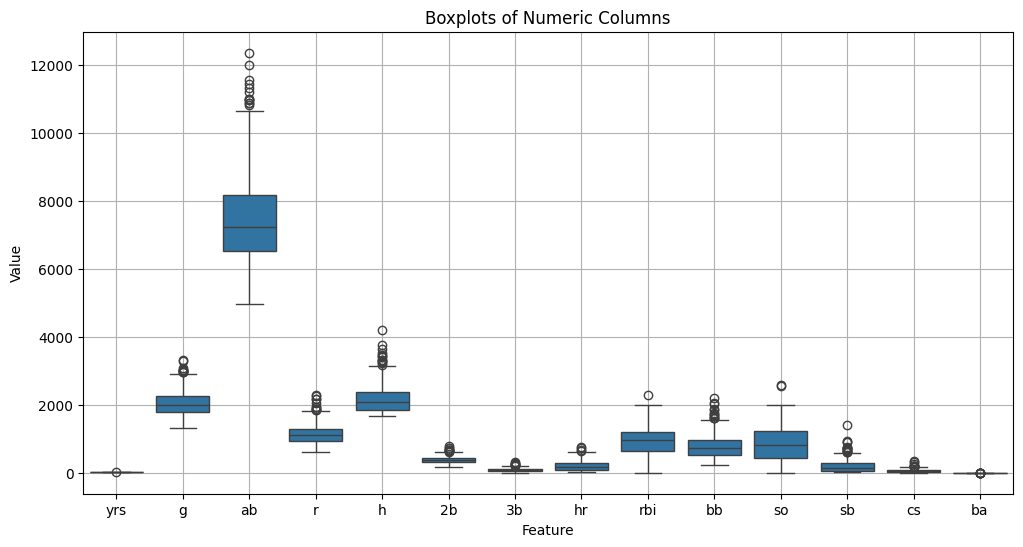

In [14]:
features_melted = X.melt(var_name='Feature', value_name='Value')
plt.figure(figsize=(12, 6))
sns.boxplot(x='Feature', y='Value', data=features_melted)
plt.title("Boxplots of Numeric Columns")
plt.grid(True)
plt.show()

#### IQR-based outlier detection with 1.5×IQR threshold, quantification of outlier prevalence per feature

In [15]:
outliers = []
outliersP = []

for col in X.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_rows = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers.append(outlier_rows.shape[0])

    percentage = (outlier_rows.shape[0]/df.shape[0]) * 100
    outliersP.append(round(percentage,2))

print("done")

done


In [16]:
print(f"outliers in each feature: {outliers}")
print(f"percentage of outliers in each feature: {outliersP}")

outliers in each feature: [1, 11, 13, 11, 13, 10, 8, 4, 1, 12, 2, 15, 10, 10]
percentage of outliers in each feature: [0.22, 2.37, 2.8, 2.37, 2.8, 2.16, 1.72, 0.86, 0.22, 2.59, 0.43, 3.23, 2.16, 2.16]


In [17]:
total = 0

for outlier in outliers:
    total += outlier

total = (total/df.shape[0]) * 100
total = round(total,2)
print(f"the total percentage of outliers in the dataset: {total}%")

the total percentage of outliers in the dataset: 26.08%


### Model Worflow

#### Train-Test split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Feature Scaling
Employed RobustScaler instead of StandardScaler due to the presence of outliers in baseball statistics. The scaler was fitted on training data only, with test data transformed using the same scaling parameters to prevent data leakage

In [19]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Finding the optimal K
Determined optimal k value through 5-fold cross-validation, testing k from 1 to 20 and selecting k based on highest average accuracy

In [20]:
best_score = 0
best_k = 1

for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,X_train, y_train, cv=5)
    avg_score = scores.mean()

    if avg_score > best_score:
        best_score = avg_score
        best_k = k
        
print(f"the optimal k is: {best_k}")

the optimal k is: 11


#### Model Instantiation

In [21]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [22]:
y_pred = model.predict(X_test)

#### Model Evaluation

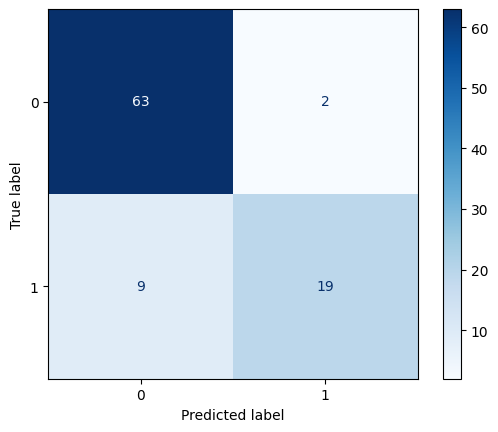

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = model.classes_)
disp.plot(cmap='Blues')
plt.show()

In [24]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92        65
           1       0.90      0.68      0.78        28

    accuracy                           0.88        93
   macro avg       0.89      0.82      0.85        93
weighted avg       0.88      0.88      0.88        93

